In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFECV, f_regression, mutual_info_regression
from xgboost import XGBRegressor
from sklearn import set_config
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
set_config(transform_output='pandas')



In [ ]:
class HousePriceRegressor:
    """
    Regression pipeline for predicting whether a house price.
    Steps included:
        - preprocessing
        - encoding
        - model training
        - hyperparameter tuning.
    """

    def __init__(self, path):
        """
        initialize the classifier with data set
        Parameters:
        - path to csv file
        """

        self.data = pd.read_csv(path)
        self.create_features()
        self.ordinal_features = [
            'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
            'BsmtFinType1', 'KitchenQual', 'HeatingQC', 'GarageQual',
            'GarageCond', 'PoolQC', 'Fence'
        ]
        self.log_transform_target = False

        # order is: excellent, good, typical/average, fair, poor, (nor available)
        self.order_categories = [
            ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
            ['Gd', 'Av', 'Mn', 'No', 'NA'],
            ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
            ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
            ['Ex', 'Gd', 'TA', 'Fa', 'NA'],
            ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA']
        ]
        self.model = None
        self.search = None


    def check_and_transform_skewness(self, skew_threshold=0.5):
        """
        Checks skewness of numeric features and stores highly skewed ones.
        """
        numeric_data = self.X_train.select_dtypes(include=np.number)
        
        skew_df = pd.DataFrame(numeric_data.columns, columns=['Feature'])
        skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: skew(numeric_data[feature].dropna()))
        skew_df['Absolute Skew'] = skew_df['Skew'].abs()
        skew_df['Skewed'] = skew_df['Absolute Skew'] >= skew_threshold

        self.skewed_features = skew_df[skew_df['Skewed']]['Feature'].tolist()

        return skew_df

    def create_features(self):
        df = self.data

        # new Features
        df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
        df['Age'] = df['YrSold'] - df['YearBuilt']
        df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
        df['IsRemodeled'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)
        df['HasPool'] = (df['PoolArea'] > 0).astype(int)
        #df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
        df['HasGarage'] = df['GarageType'].notna().astype(int)
        df['OverallGrade'] = df['OverallQual'] * df['OverallCond']
        df['IsNew'] = (df['YearBuilt'] == df['YrSold']).astype(int)

        df['YrSold'] = df['YrSold'].astype(str)
        df['MoSold'] = df['MoSold'].astype(str)

        self.data = df



    def prepare_data(self):
        """
        prepare training and test sets
        identify categorical and numerical columns
        """

        #self.y = self.data.pop('SalePrice')
        self.data['SalePrice'] = np.log1p(self.data['SalePrice'])
        self.y = self.data.pop('SalePrice')
        self.X = self.data.drop(columns=['Fireplaces'])

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )
        self.X_num = self.X_train.select_dtypes(include='number').columns
        self.X_cat = self.X_train.select_dtypes(exclude='number').columns

        self.oh_features = [col for col in self.X_cat if col not in self.ordinal_features]

    def build_preprocessor(self):
        """
        constructs the preprocessing pipeline for numerical and categorical data
        """

        self.check_and_transform_skewness()

        # impute missing values with mean for numerical features and 'NA' for categorical features
        num_imputer = SimpleImputer(strategy='mean')
        cat_imputer = SimpleImputer(strategy='constant', fill_value='NA')

        # encode categorical data with ordinal encoder for features that have a 'logical' order
        # encode categorical data with one hot encoder for features with no order
        oh_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False)
        ord_encoder = OrdinalEncoder(categories=self.order_categories)

        cat_encoder = ColumnTransformer(transformers=[
            ('oh_encoder', oh_encoder, self.oh_features),
            ('ord_encoder', ord_encoder, self.ordinal_features)],
            verbose_feature_names_out=False)

        # full pipelines including both imputers and encoders
        self.num_pipeline = Pipeline([('num_imputer', num_imputer)])
        self.cat_pipeline = Pipeline([
            ('cat_imputer', cat_imputer),
            ('cat_encoder', cat_encoder)
        ])

        # final preprocessor
        self.preprocessor = ColumnTransformer(transformers=[
            ('num_pipe', self.num_pipeline, self.X_num),
            ('cat_pipe', self.cat_pipeline, self.X_cat)
        ], verbose_feature_names_out=False)

    def build_model(self, model_type="knn"):
        """
        build a complete pipeline using KNN or random forest including preprocessing
        """

        if model_type == "knn":
            self.model = Pipeline([
                ("preprocessor", self.preprocessor),
                ("scaler", PowerTransformer()),
                ("feat_select", SelectKBest()),
                ("knn", KNeighborsRegressor())
            ])
        elif model_type == "rf":
            self.model = Pipeline([
                ("preprocessor", self.preprocessor),
                ("rf", RandomForestRegressor())
            ])
        elif model_type == "xgb":
            self.model = Pipeline([
                ("preprocessor", self.preprocessor),
                ("xgb", XGBRegressor())
            ])



    def train(self, model_type="knn", search_type = "random", n_iter=100, cv=3):
        """
        Trains the model and performs randomized hyperparameter search on the model
        """

    # ranges were found and refined after several tuning iterations
        if model_type == "knn":
            param_grid = {
                'preprocessor__num_pipe__num_imputer__strategy': ['mean', 'median'],
                'preprocessor__cat_pipe__cat_imputer__strategy': ['constant'],
                'scaler': [StandardScaler()],
                'feat_select__score_func': [mutual_info_regression, f_regression],
                'feat_select__k': range(13, 16),
                'knn__n_neighbors': range(5, 12, 2),
                'knn__weights': ['distance'],
                'knn__p': np.arange(1.5, 3.5, 0.5)
            }

        elif model_type == "rf":
            param_grid = {
                'rf__max_depth': [10, 60, 80, 90, 100, None],
                'rf__min_samples_leaf': [1, 2, 4],
                'rf__min_samples_split': [2, 5, 10],
                'rf__n_estimators': [200, 800, 1400, 2000]
            }
        elif model_type == "xgb":
            param_grid = {
                'preprocessor__num_pipe__num_imputer__strategy': ['mean'],
                'preprocessor__cat_pipe__cat_imputer__strategy': ['constant'],
                'xgb__learning_rate': np.arange(0.07, 0.09, 0.01),
                'xgb__max_depth': np.arange(3, 4, 1),
                'xgb__subsample': np.arange(0.7, 0.9, 0.05), # 0.7, 1.0, 0.05
                'xgb__colsample_bytree': np.arange(0.75, 0.95, 0.05), # 0.7, 1.0, 0.05
                'xgb__n_estimators': [500], # 100, 300, 500
                'xgb__reg_alpha': [0.5], #np.arange(0, .7, 0.1),        # 0, 0.1, 0.5
                'xgb__reg_lambda': np.arange(0.35, 0.45, 0.05),    
                'xgb__min_child_weight': np.arange(1, 2, 1)   

            }
        
        if search_type == "random":
            self.search = RandomizedSearchCV(
                self.model,
                param_distributions=param_grid,
                n_iter=n_iter,
                cv=cv,
                verbose=1,
                scoring = 'r2',
                n_jobs=-1,
                random_state=42
                )
        elif search_type == "grid":
            self.search = GridSearchCV(
                self.model,
                param_grid,
                cv=cv,
                scoring='r2',
                n_jobs=-1, #uses all available CPU cores, can slow down other applications
                verbose=1)

        self.search.fit(self.X_train, self.y_train) # hier soll ein output kommen (die pipeline)
        print("Best Parameters and corresponding score from training data:")
        print(self.search.best_params_)
        print(self.search.best_score_)

        return self.search.best_estimator_
    
    def evaluate(self):
        """
        evaluates the tuned model on the test set
        """
        y_pred_log = self.search.predict(self.X_test)
        y_pred = np.expm1(y_pred_log)
        y_true = np.expm1(self.y_test)

        score = r2_score(y_true, y_pred)
        print("R2 score on test data:", score)


    def plot_predictions(self, model_name=None):
        #y_pred = self.search.predict(self.X_test)
        y_pred_log = self.search.predict(self.X_test)
        y_pred = np.expm1(y_pred_log)
        y_true = np.expm1(self.y_test)


        plt.figure(figsize=(6,6))
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
        plt.plot([y_true.min(), y_true.max()],
                 [y_true.min(), y_true.max()], color = "grey", linewidth=1)

        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")

        name = model_name if model_name else type(self.search.best_estimator_).__name__
        plt.title(f"{name}: True vs Predicted")
        plt.tight_layout()
        plt.show()


Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best Parameters and corresponding score from training data:
{'feat_select__k': 13, 'feat_select__score_func': <function mutual_info_regression at 0x169b17430>, 'knn__n_neighbors': 7, 'knn__p': 1.5, 'knn__weights': 'distance', 'preprocessor__cat_pipe__cat_imputer__strategy': 'constant', 'preprocessor__num_pipe__num_imputer__strategy': 'mean', 'scaler': StandardScaler()}
0.8439144854640732
R2 score on test data: 0.8573369114575227


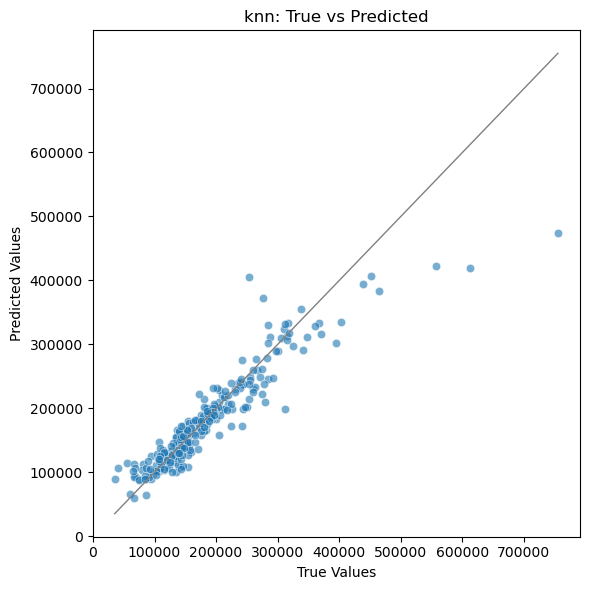

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer())]),
                                                  Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtF...
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold',
       'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('scaler', StandardScaler()),
                ('feat_select',
                 SelectKBest(k=13,
                             score_func=<function mutual_info_regression at 0x169b17430>)),
                ('knn',
                 KNeighborsRegressor(n_neighbors=7, p=1.5,
                                     weights='distance'))])

In [11]:
regressor = HousePriceRegressor("train.csv")
regressor.prepare_data()
regressor.build_preprocessor()
regressor.build_model(model_type="knn")
regressor.train(model_type="knn", search_type="grid")
regressor.evaluate()
regressor.plot_predictions(model_name="knn")
regressor.search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters and corresponding score from training data:
{'rf__n_estimators': 800, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': 90}
0.8778643476735674
R2 score on test data: 0.883023579269504


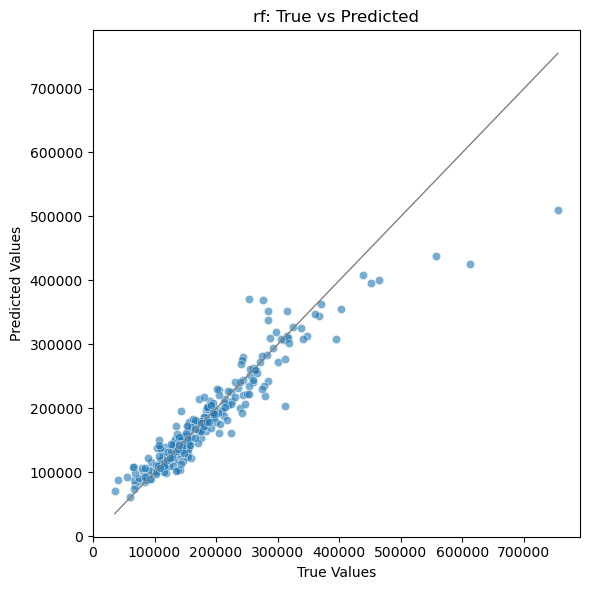

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer())]),
                                                  Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtF...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold',
       'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('rf', RandomForestRegressor(max_depth=90, n_estimators=800))])

In [12]:
regressor = HousePriceRegressor("train.csv")
regressor.prepare_data()
regressor.build_preprocessor()
regressor.build_model(model_type="rf")
regressor.train(model_type="rf", search_type = "random")
regressor.evaluate()
regressor.plot_predictions(model_name="rf")
regressor.search.best_estimator_

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best Parameters and corresponding score from training data:
{'preprocessor__cat_pipe__cat_imputer__strategy': 'constant', 'preprocessor__num_pipe__num_imputer__strategy': 'mean', 'xgb__colsample_bytree': 0.75, 'xgb__learning_rate': 0.07, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 500, 'xgb__reg_alpha': 0.5, 'xgb__reg_lambda': 0.44999999999999996, 'xgb__subsample': 0.8}
0.8978223701751737
R2 score on test data: 0.9025444907731424


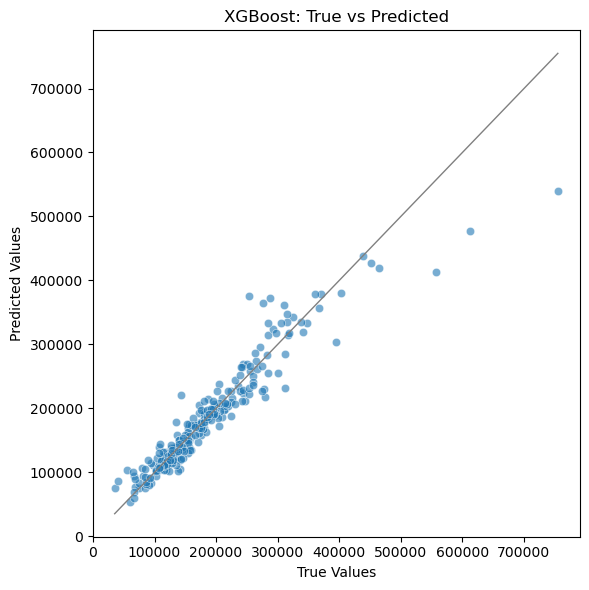

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer())]),
                                                  Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtF...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.07,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=500,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [13]:
regressor = HousePriceRegressor("train.csv")
regressor.prepare_data()
regressor.build_preprocessor()
regressor.build_model(model_type="xgb")
regressor.train(model_type="xgb", search_type="grid")
regressor.evaluate()
regressor.plot_predictions(model_name="XGBoost")
regressor.search.best_estimator_